## Abstract

In this notebook, we study the effect of various layers on the performance of convolutional neural network(CNN) model for image classification. We compare the baseline CNN model having 3 convolutional layers, by modifying the architecture with additional layers such as Batch Normalization, varying activation functions(sigmoid, relu) and adding dropout layers.

**Champion Model:**

5-CNN Max Pooling Layer + ReLU Activation Function + BatchNormalization
* Train Accuracy - 80.19
* Train Loss - 0.28
* Validation Accuracy - 77.63
* Validation Loss - 0.62

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Data Setup

In [2]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:11<00:00, 14706252.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## CNN Model

In [3]:
# Custom CNN Model

class Image_classifier(nn.Module):
    def __init__(self, use_BN=False, use_dropout=False, dropout=0.2, num_layers=3, act_func='relu'):
        super(Image_classifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        num_filters = 32
        # activation_function
        activation_func = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(0.1),
        }

        # define layers
        layers = []
        input_channels = 3
        num_filters = 32
        num_channels = 3
        for i in range(num_layers):
            layers.append(nn.Conv2d(input_channels, num_filters, kernel_size=3, padding=1))
            if use_BN:
                layers.append(nn.BatchNorm2d(num_filters))
            layers.append(activation_func[act_func])
            layers.append(nn.MaxPool2d(2))

            input_channels = num_filters
            num_filters *= 2

        self.conv = nn.Sequential(*layers)
        self.flatten_size = self._get_flatten_size()

        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout) if use_dropout else None

    # Function to estimate the output size of last CNN layer
    def _get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, 32, 32)
        out = self.conv(dummy_input)
        return out.numel()

    def forward(self, x):

        out = self.conv(x)
        out = out.view(out.size(0), -1)  # Flatten
        out = F.relu(self.fc1(out))
        if self.dropout:
            out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [4]:
# Function - Model Training
def train_validation(model, train_loader, num_epochs):
    criterion = nn.CrossEntropyLoss() # Loss func
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam Optimizer

    train_acc_list =[]
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    train_size = 0
    train_pred = 0
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    model.train()

    for epoch in range(num_epochs):
        curr_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # prediction
            output = model(images)
            # compute loss
            loss = criterion(output, labels)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_size += labels.size(0)
            train_pred += (predicted == labels).sum().item()

        # Training accuracy and loss
        train_accuracy = 100 * train_pred / train_size
        train_loss = curr_loss / len(train_loader)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)

        # Validation accuracy and loss
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss = val_loss / len(val_loader)
        val_acc_list.append(val_accuracy)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - train accuracy : {train_accuracy:.2f} | train loss : {train_loss:.2f} \n | validation accuracy : {val_accuracy:.2f} | validation loss : {val_loss:.2f}")

    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [5]:
# Plotting function
def plot_curves(train_acc, val_acc, train_loss, val_loss, num_epochs):
    epochs = range(1, num_epochs + 1)

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Relu activation Function

In [6]:
# Base Model with 3 Conv layers - Relu Activation

model = Image_classifier(use_BN=False, use_dropout=False, dropout=0.2, num_layers=3, act_func='relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 46.22 | train loss : 1.48 
 | validation accuracy : 57.10 | validation loss : 1.20
Epoch 2/10 - train accuracy : 53.42 | train loss : 1.10 
 | validation accuracy : 60.65 | validation loss : 1.02
Epoch 3/10 - train accuracy : 57.81 | train loss : 0.94 
 | validation accuracy : 62.53 | validation loss : 0.96
Epoch 4/10 - train accuracy : 60.84 | train loss : 0.85 
 | validation accuracy : 64.05 | validation loss : 0.89
Epoch 5/10 - train accuracy : 63.19 | train loss : 0.79 
 | validation accuracy : 65.22 | validation loss : 0.86
Epoch 6/10 - train accuracy : 65.04 | train loss : 0.73 
 | validation accuracy : 66.49 | validation loss : 0.80
Epoch 7/10 - train accuracy : 66.61 | train loss : 0.69 
 | validation accuracy : 67.34 | validation loss : 0.83
Epoch 8/10 - train accuracy : 67.94 | train loss : 0.66 
 | validation accuracy : 68.13 | validation loss : 0.78
Epoch 9/10 - train accuracy : 69.12 | train loss : 0.61 
 | validation accuracy : 68.77 | valida

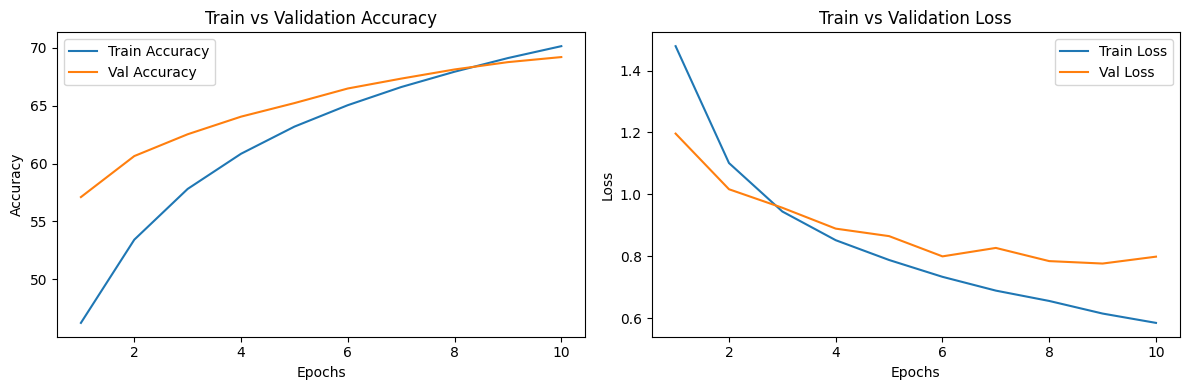

In [7]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [8]:
# Model with Batch Normalization

model = Image_classifier(use_BN=True, use_dropout=False, dropout=0.2, num_layers=3, act_func='relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 54.47 | train loss : 1.26 
 | validation accuracy : 62.00 | validation loss : 1.06
Epoch 2/10 - train accuracy : 60.09 | train loss : 0.96 
 | validation accuracy : 64.19 | validation loss : 0.98
Epoch 3/10 - train accuracy : 63.40 | train loss : 0.85 
 | validation accuracy : 65.98 | validation loss : 0.88
Epoch 4/10 - train accuracy : 65.56 | train loss : 0.79 
 | validation accuracy : 66.92 | validation loss : 0.89
Epoch 5/10 - train accuracy : 67.28 | train loss : 0.74 
 | validation accuracy : 68.10 | validation loss : 0.79
Epoch 6/10 - train accuracy : 68.68 | train loss : 0.70 
 | validation accuracy : 69.00 | validation loss : 0.77
Epoch 7/10 - train accuracy : 69.83 | train loss : 0.66 
 | validation accuracy : 69.54 | validation loss : 0.80
Epoch 8/10 - train accuracy : 70.84 | train loss : 0.63 
 | validation accuracy : 70.14 | validation loss : 0.77
Epoch 9/10 - train accuracy : 71.75 | train loss : 0.60 
 | validation accuracy : 70.59 | valida

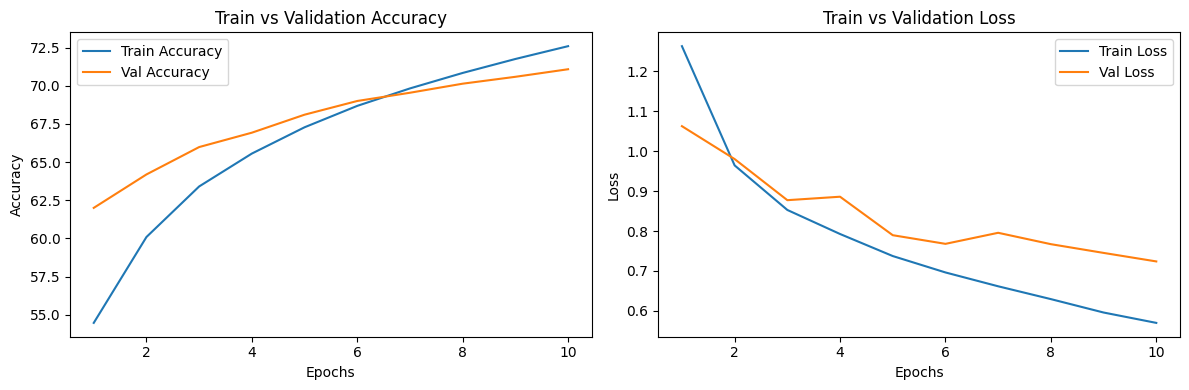

In [9]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [10]:
# Model with Dropout

model = Image_classifier(use_BN=False, use_dropout=True, dropout=0.2, num_layers=3, act_func='relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 43.76 | train loss : 1.54 
 | validation accuracy : 51.53 | validation loss : 1.34
Epoch 2/10 - train accuracy : 50.24 | train loss : 1.21 
 | validation accuracy : 55.57 | validation loss : 1.13
Epoch 3/10 - train accuracy : 54.29 | train loss : 1.06 
 | validation accuracy : 58.34 | validation loss : 1.04
Epoch 4/10 - train accuracy : 57.10 | train loss : 0.98 
 | validation accuracy : 60.06 | validation loss : 0.99
Epoch 5/10 - train accuracy : 59.19 | train loss : 0.92 
 | validation accuracy : 61.13 | validation loss : 0.99
Epoch 6/10 - train accuracy : 60.92 | train loss : 0.86 
 | validation accuracy : 62.32 | validation loss : 0.93
Epoch 7/10 - train accuracy : 62.35 | train loss : 0.82 
 | validation accuracy : 63.22 | validation loss : 0.92
Epoch 8/10 - train accuracy : 63.56 | train loss : 0.79 
 | validation accuracy : 64.03 | validation loss : 0.89
Epoch 9/10 - train accuracy : 64.67 | train loss : 0.75 
 | validation accuracy : 64.63 | valida

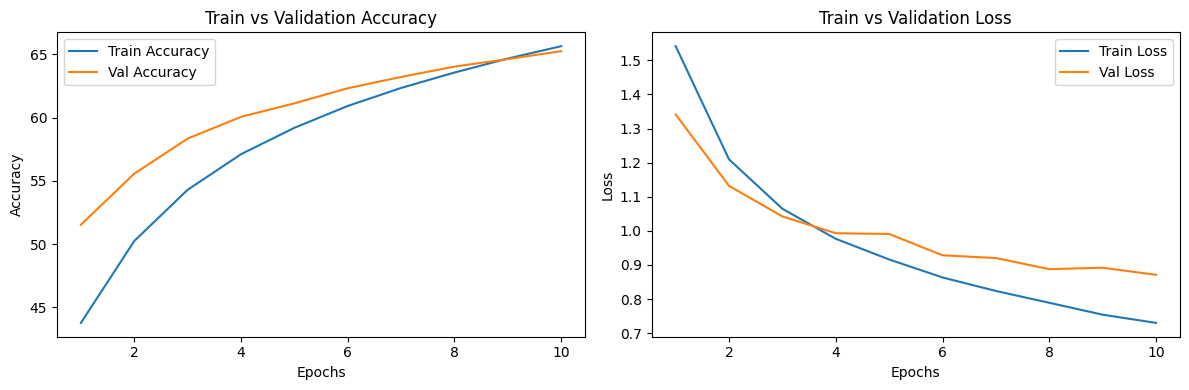

In [11]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [6]:
# Model with Batch Normalization and Dropout

model = Image_classifier(use_BN=True, use_dropout=True, dropout=0.2, num_layers=3, act_func='relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 51.92 | train loss : 1.32 
 | validation accuracy : 62.51 | validation loss : 1.05
Epoch 2/10 - train accuracy : 58.60 | train loss : 0.98 
 | validation accuracy : 64.66 | validation loss : 0.96
Epoch 3/10 - train accuracy : 62.27 | train loss : 0.87 
 | validation accuracy : 66.45 | validation loss : 0.86
Epoch 4/10 - train accuracy : 64.83 | train loss : 0.78 
 | validation accuracy : 67.92 | validation loss : 0.82
Epoch 5/10 - train accuracy : 66.73 | train loss : 0.74 
 | validation accuracy : 68.65 | validation loss : 0.84
Epoch 6/10 - train accuracy : 68.28 | train loss : 0.69 
 | validation accuracy : 69.46 | validation loss : 0.78
Epoch 7/10 - train accuracy : 69.59 | train loss : 0.65 
 | validation accuracy : 70.31 | validation loss : 0.72
Epoch 8/10 - train accuracy : 70.73 | train loss : 0.61 
 | validation accuracy : 70.91 | validation loss : 0.73
Epoch 9/10 - train accuracy : 71.73 | train loss : 0.58 
 | validation accuracy : 71.42 | valida

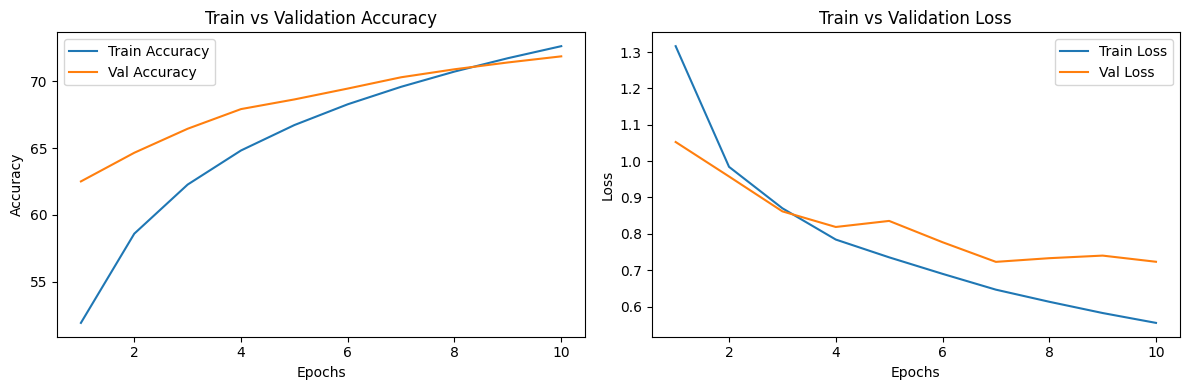

In [7]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

### Sigmoid Activation Function

In [8]:
# Base Model with 3 Conv layers - Sigmoid Activation

model = Image_classifier(use_BN=False, use_dropout=False, dropout=0.2, num_layers=3, act_func='sigmoid').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 20.45 | train loss : 2.10 
 | validation accuracy : 30.43 | validation loss : 1.86
Epoch 2/10 - train accuracy : 27.69 | train loss : 1.75 
 | validation accuracy : 34.70 | validation loss : 1.65
Epoch 3/10 - train accuracy : 32.72 | train loss : 1.56 
 | validation accuracy : 38.39 | validation loss : 1.47
Epoch 4/10 - train accuracy : 36.36 | train loss : 1.44 
 | validation accuracy : 41.23 | validation loss : 1.38
Epoch 5/10 - train accuracy : 39.18 | train loss : 1.36 
 | validation accuracy : 43.22 | validation loss : 1.35
Epoch 6/10 - train accuracy : 41.43 | train loss : 1.30 
 | validation accuracy : 44.84 | validation loss : 1.29
Epoch 7/10 - train accuracy : 43.32 | train loss : 1.25 
 | validation accuracy : 46.40 | validation loss : 1.22
Epoch 8/10 - train accuracy : 45.00 | train loss : 1.19 
 | validation accuracy : 47.61 | validation loss : 1.21
Epoch 9/10 - train accuracy : 46.49 | train loss : 1.15 
 | validation accuracy : 48.95 | valida

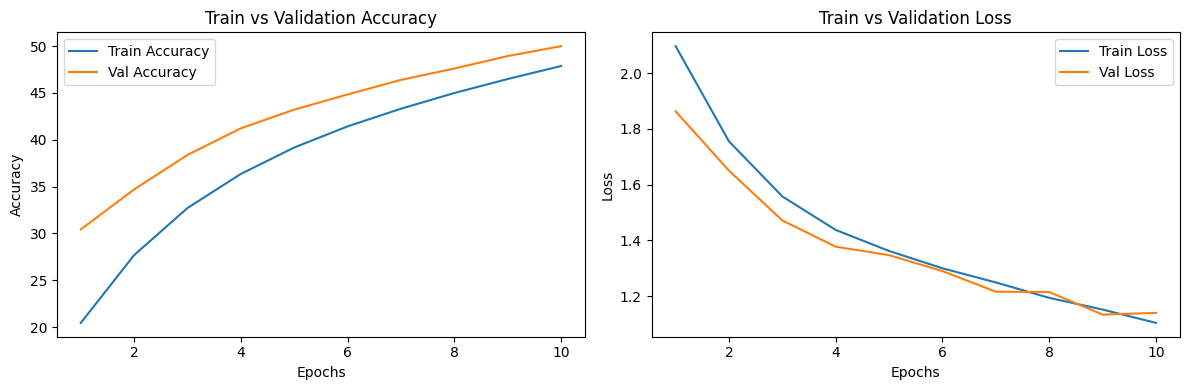

In [9]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [10]:
# Model with Batch Normalization

model = Image_classifier(use_BN=True, use_dropout=False, dropout=0.2, num_layers=3, act_func='sigmoid').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 36.43 | train loss : 1.68 
 | validation accuracy : 46.16 | validation loss : 1.44
Epoch 2/10 - train accuracy : 43.84 | train loss : 1.32 
 | validation accuracy : 49.89 | validation loss : 1.26
Epoch 3/10 - train accuracy : 48.27 | train loss : 1.16 
 | validation accuracy : 53.28 | validation loss : 1.10
Epoch 4/10 - train accuracy : 51.57 | train loss : 1.06 
 | validation accuracy : 54.52 | validation loss : 1.15
Epoch 5/10 - train accuracy : 54.13 | train loss : 0.98 
 | validation accuracy : 56.49 | validation loss : 1.01
Epoch 6/10 - train accuracy : 56.27 | train loss : 0.92 
 | validation accuracy : 58.01 | validation loss : 0.96
Epoch 7/10 - train accuracy : 58.02 | train loss : 0.88 
 | validation accuracy : 59.51 | validation loss : 0.88
Epoch 8/10 - train accuracy : 59.48 | train loss : 0.84 
 | validation accuracy : 60.78 | validation loss : 0.87
Epoch 9/10 - train accuracy : 60.77 | train loss : 0.81 
 | validation accuracy : 61.74 | valida

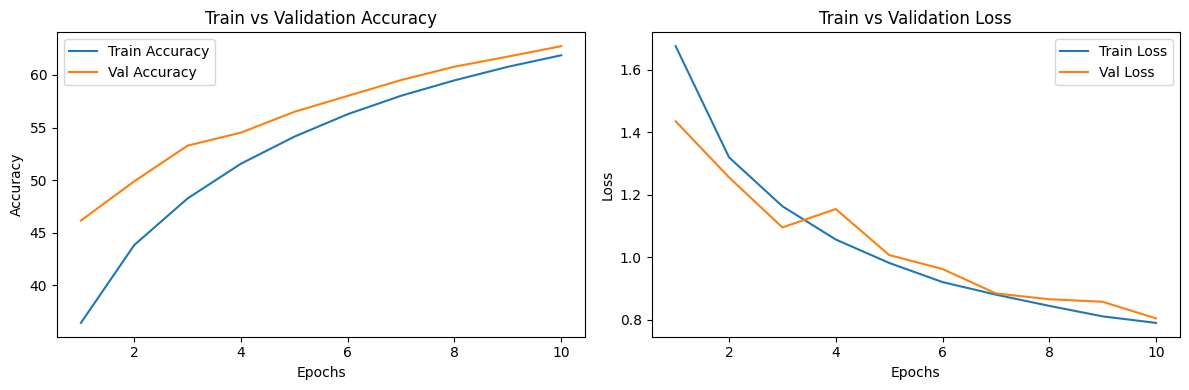

In [11]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

### Leaky_Relu Activation

In [12]:
# Base Model with 3 Conv layers - Leaky ReLU Activation

model = Image_classifier(use_BN=False, use_dropout=False, dropout=0.2, num_layers=3, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 47.35 | train loss : 1.44 
 | validation accuracy : 58.94 | validation loss : 1.13
Epoch 2/10 - train accuracy : 55.61 | train loss : 1.02 
 | validation accuracy : 63.01 | validation loss : 0.92
Epoch 3/10 - train accuracy : 60.40 | train loss : 0.85 
 | validation accuracy : 65.54 | validation loss : 0.86
Epoch 4/10 - train accuracy : 63.75 | train loss : 0.75 
 | validation accuracy : 67.30 | validation loss : 0.81
Epoch 5/10 - train accuracy : 66.40 | train loss : 0.66 
 | validation accuracy : 68.72 | validation loss : 0.74
Epoch 6/10 - train accuracy : 68.53 | train loss : 0.60 
 | validation accuracy : 69.73 | validation loss : 0.74
Epoch 7/10 - train accuracy : 70.26 | train loss : 0.55 
 | validation accuracy : 70.79 | validation loss : 0.67
Epoch 8/10 - train accuracy : 71.79 | train loss : 0.50 
 | validation accuracy : 71.34 | validation loss : 0.75
Epoch 9/10 - train accuracy : 73.14 | train loss : 0.46 
 | validation accuracy : 71.93 | valida

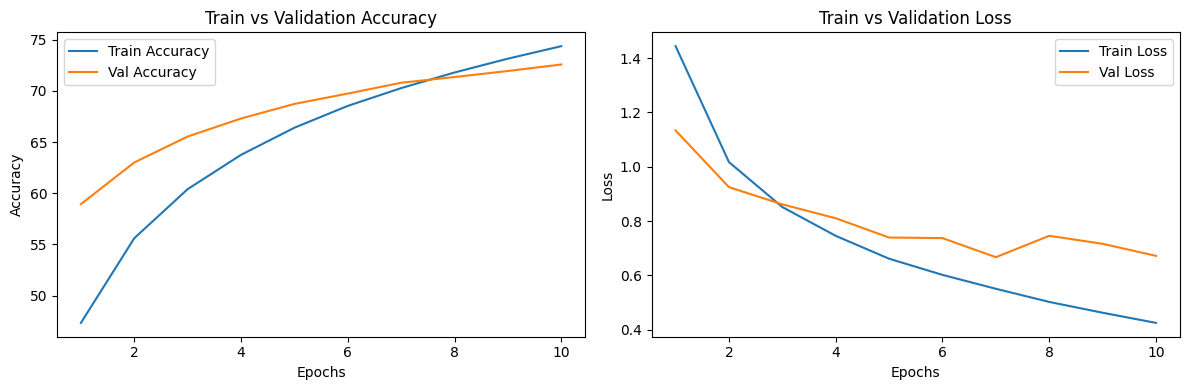

In [13]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [14]:
# Model with Batch Normalization

model = Image_classifier(use_BN=True, use_dropout=False, dropout=0.2, num_layers=3, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 56.12 | train loss : 1.21 
 | validation accuracy : 65.10 | validation loss : 1.00
Epoch 2/10 - train accuracy : 63.10 | train loss : 0.85 
 | validation accuracy : 68.94 | validation loss : 0.79
Epoch 3/10 - train accuracy : 66.84 | train loss : 0.74 
 | validation accuracy : 70.67 | validation loss : 0.75
Epoch 4/10 - train accuracy : 69.38 | train loss : 0.66 
 | validation accuracy : 71.87 | validation loss : 0.71
Epoch 5/10 - train accuracy : 71.21 | train loss : 0.61 
 | validation accuracy : 72.92 | validation loss : 0.66
Epoch 6/10 - train accuracy : 72.72 | train loss : 0.56 
 | validation accuracy : 73.43 | validation loss : 0.71
Epoch 7/10 - train accuracy : 74.00 | train loss : 0.53 
 | validation accuracy : 74.05 | validation loss : 0.67
Epoch 8/10 - train accuracy : 75.15 | train loss : 0.49 
 | validation accuracy : 74.56 | validation loss : 0.65
Epoch 9/10 - train accuracy : 76.13 | train loss : 0.46 
 | validation accuracy : 75.11 | valida

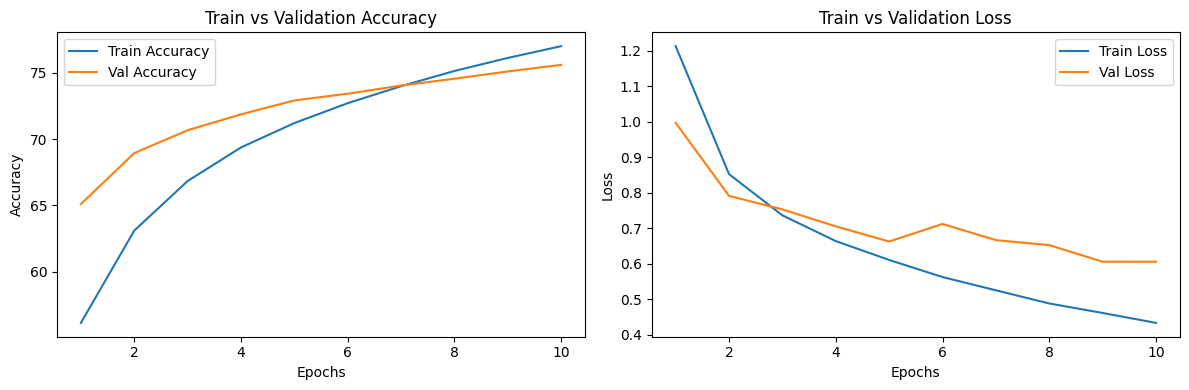

In [15]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [16]:
# Model with Dropout

model = Image_classifier(use_BN=False, use_dropout=True, dropout=0.2, num_layers=3, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 43.00 | train loss : 1.55 
 | validation accuracy : 53.54 | validation loss : 1.29
Epoch 2/10 - train accuracy : 51.11 | train loss : 1.14 
 | validation accuracy : 58.09 | validation loss : 1.05
Epoch 3/10 - train accuracy : 56.15 | train loss : 0.96 
 | validation accuracy : 61.05 | validation loss : 0.95
Epoch 4/10 - train accuracy : 59.76 | train loss : 0.84 
 | validation accuracy : 63.48 | validation loss : 0.86
Epoch 5/10 - train accuracy : 62.53 | train loss : 0.76 
 | validation accuracy : 65.26 | validation loss : 0.80
Epoch 6/10 - train accuracy : 64.77 | train loss : 0.69 
 | validation accuracy : 66.75 | validation loss : 0.76
Epoch 7/10 - train accuracy : 66.57 | train loss : 0.65 
 | validation accuracy : 67.83 | validation loss : 0.77
Epoch 8/10 - train accuracy : 68.12 | train loss : 0.60 
 | validation accuracy : 68.57 | validation loss : 0.79
Epoch 9/10 - train accuracy : 69.46 | train loss : 0.57 
 | validation accuracy : 69.34 | valida

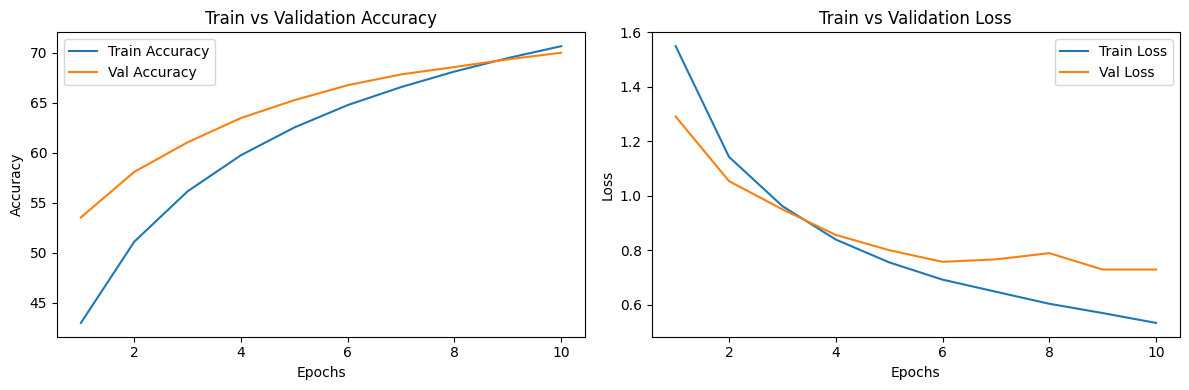

In [17]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [18]:
# Model with BN and Dropout

model = Image_classifier(use_BN=True, use_dropout=True, dropout=0.2, num_layers=3, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 51.41 | train loss : 1.33 
 | validation accuracy : 60.99 | validation loss : 1.08
Epoch 2/10 - train accuracy : 58.57 | train loss : 0.97 
 | validation accuracy : 64.75 | validation loss : 0.91
Epoch 3/10 - train accuracy : 62.35 | train loss : 0.86 
 | validation accuracy : 66.65 | validation loss : 0.85
Epoch 4/10 - train accuracy : 64.89 | train loss : 0.79 
 | validation accuracy : 68.23 | validation loss : 0.80
Epoch 5/10 - train accuracy : 66.87 | train loss : 0.72 
 | validation accuracy : 69.23 | validation loss : 0.80
Epoch 6/10 - train accuracy : 68.42 | train loss : 0.68 
 | validation accuracy : 69.92 | validation loss : 0.79
Epoch 7/10 - train accuracy : 69.69 | train loss : 0.65 
 | validation accuracy : 70.73 | validation loss : 0.72
Epoch 8/10 - train accuracy : 70.85 | train loss : 0.61 
 | validation accuracy : 71.20 | validation loss : 0.76
Epoch 9/10 - train accuracy : 71.85 | train loss : 0.58 
 | validation accuracy : 71.89 | valida

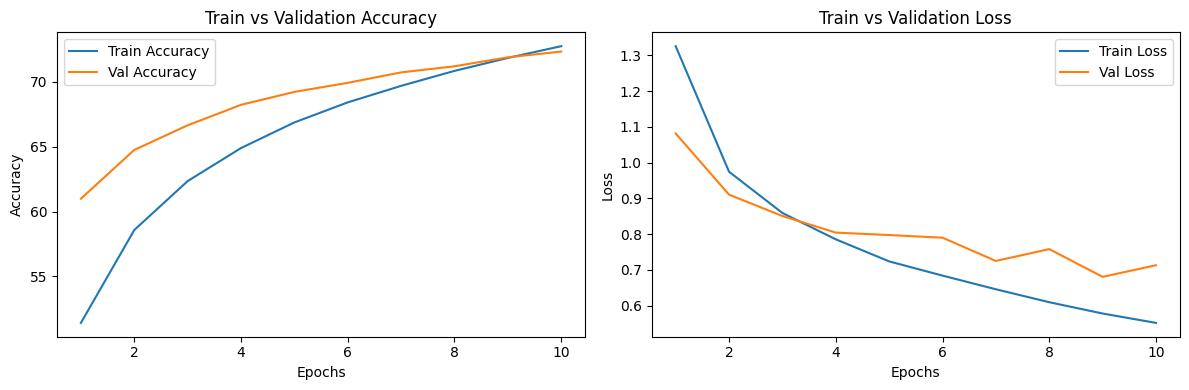

In [19]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

## More Conv Layers -  Depth (5)

In [20]:
# Model with BN and Dropout

model = Image_classifier(use_BN=False, use_dropout=False, dropout=0.2, num_layers=5, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 44.08 | train loss : 1.49 
 | validation accuracy : 58.09 | validation loss : 1.16
Epoch 2/10 - train accuracy : 53.96 | train loss : 1.01 
 | validation accuracy : 63.26 | validation loss : 0.91
Epoch 3/10 - train accuracy : 60.11 | train loss : 0.79 
 | validation accuracy : 66.68 | validation loss : 0.78
Epoch 4/10 - train accuracy : 64.51 | train loss : 0.64 
 | validation accuracy : 69.10 | validation loss : 0.69
Epoch 5/10 - train accuracy : 67.86 | train loss : 0.54 
 | validation accuracy : 70.85 | validation loss : 0.67
Epoch 6/10 - train accuracy : 70.54 | train loss : 0.47 
 | validation accuracy : 71.98 | validation loss : 0.67
Epoch 7/10 - train accuracy : 72.76 | train loss : 0.40 
 | validation accuracy : 72.74 | validation loss : 0.71
Epoch 8/10 - train accuracy : 74.66 | train loss : 0.35 
 | validation accuracy : 73.58 | validation loss : 0.63
Epoch 9/10 - train accuracy : 76.33 | train loss : 0.30 
 | validation accuracy : 74.20 | valida

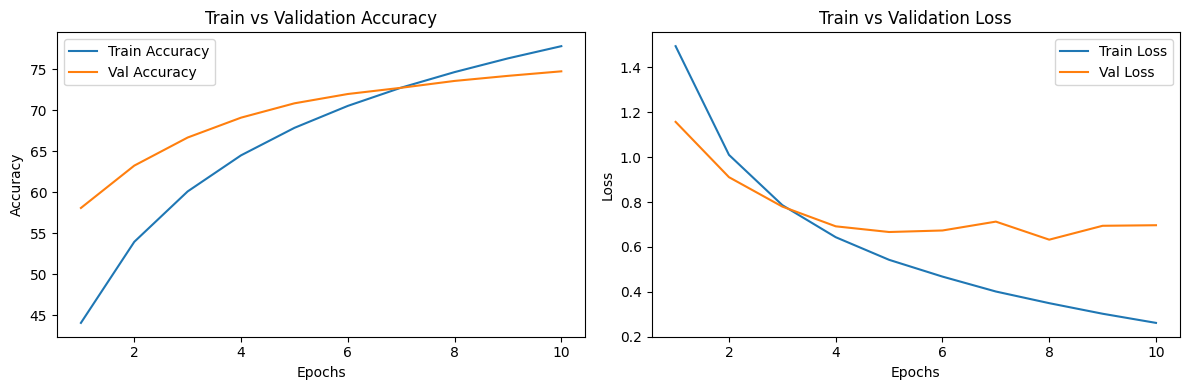

In [21]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [6]:
# Model with BN

model = Image_classifier(use_BN=True, use_dropout=False, dropout=0.2, num_layers=5, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 55.72 | train loss : 1.21 
 | validation accuracy : 65.80 | validation loss : 0.96
Epoch 2/10 - train accuracy : 63.35 | train loss : 0.83 
 | validation accuracy : 68.78 | validation loss : 0.81
Epoch 3/10 - train accuracy : 67.58 | train loss : 0.68 
 | validation accuracy : 71.39 | validation loss : 0.68
Epoch 4/10 - train accuracy : 70.62 | train loss : 0.58 
 | validation accuracy : 73.03 | validation loss : 0.65
Epoch 5/10 - train accuracy : 72.91 | train loss : 0.52 
 | validation accuracy : 74.40 | validation loss : 0.60
Epoch 6/10 - train accuracy : 74.82 | train loss : 0.46 
 | validation accuracy : 75.43 | validation loss : 0.58
Epoch 7/10 - train accuracy : 76.45 | train loss : 0.41 
 | validation accuracy : 76.28 | validation loss : 0.57
Epoch 8/10 - train accuracy : 77.84 | train loss : 0.36 
 | validation accuracy : 76.71 | validation loss : 0.62
Epoch 9/10 - train accuracy : 79.08 | train loss : 0.32 
 | validation accuracy : 77.25 | valida

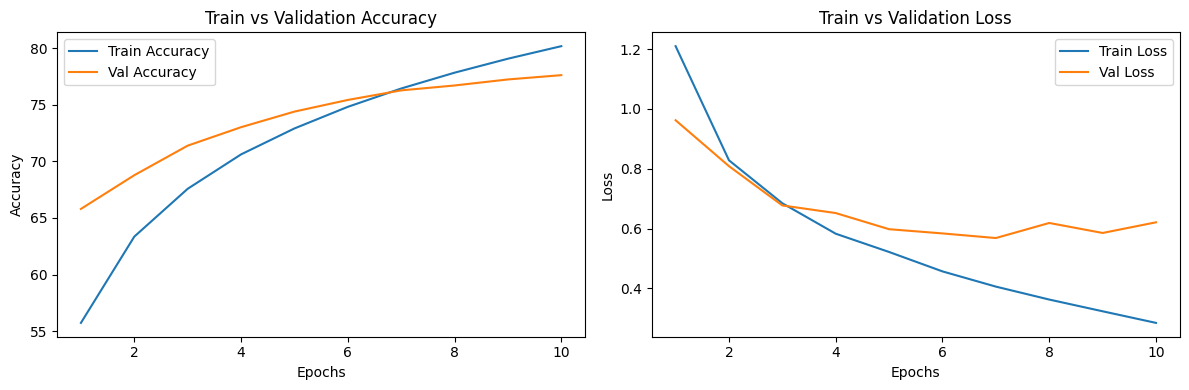

In [7]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

In [22]:
# Model with BN and Dropout

model = Image_classifier(use_BN=True, use_dropout=True, dropout=0.2, num_layers=5, act_func='leaky_relu').to(device)

train_acc, train_loss, val_accuracy, val_loss = train_validation(model, train_loader, num_epochs)

Epoch 1/10 - train accuracy : 51.44 | train loss : 1.31 
 | validation accuracy : 64.12 | validation loss : 1.01
Epoch 2/10 - train accuracy : 59.43 | train loss : 0.93 
 | validation accuracy : 67.75 | validation loss : 0.85
Epoch 3/10 - train accuracy : 64.13 | train loss : 0.77 
 | validation accuracy : 69.08 | validation loss : 0.84
Epoch 4/10 - train accuracy : 67.40 | train loss : 0.67 
 | validation accuracy : 70.87 | validation loss : 0.72
Epoch 5/10 - train accuracy : 69.95 | train loss : 0.59 
 | validation accuracy : 72.38 | validation loss : 0.66
Epoch 6/10 - train accuracy : 71.97 | train loss : 0.54 
 | validation accuracy : 73.38 | validation loss : 0.67
Epoch 7/10 - train accuracy : 73.62 | train loss : 0.48 
 | validation accuracy : 74.27 | validation loss : 0.62
Epoch 8/10 - train accuracy : 75.09 | train loss : 0.44 
 | validation accuracy : 75.09 | validation loss : 0.62
Epoch 9/10 - train accuracy : 76.36 | train loss : 0.40 
 | validation accuracy : 75.54 | valida

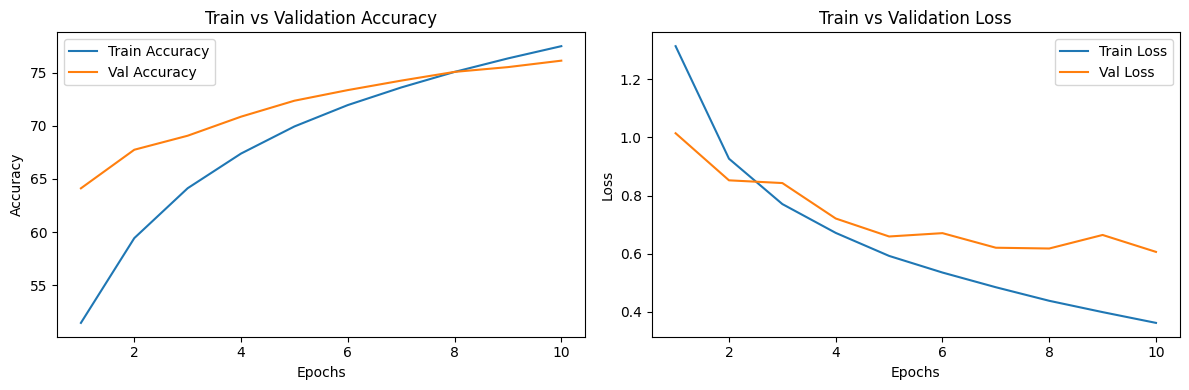

In [23]:
# Model Metrics visualization

plot_curves(train_acc, val_accuracy, train_loss, val_loss, num_epochs)

## Results

* Deeper Models perform better but may tend to overfit and stop learning if the data is too small
* Adding BatchNormalization improves the model performance significantly
* Adding Dropout layers helps generalize but seems to reduce model performance due to information loss